<a href="https://colab.research.google.com/github/yehdih/Automated-ID-Verification-System/blob/main/Agriculture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exploration du dataset**

In [1]:
import pandas as pd
import numpy as np
from io import StringIO


from google.colab import files
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
xls = pd.ExcelFile(file_name)

df = pd.read_excel(xls, sheet_name='Feuil1', header=None)

Saving SERIE_STAT_AGRI_1983 -2023_ACTUALISER (1).xlsx to SERIE_STAT_AGRI_1983 -2023_ACTUALISER (1).xlsx


In [2]:
# Find the start and end rows for each table
table1_start = df[df[0].str.contains('Tableau 1 : Evolution des superficie cultivée', na=False)].index[0]
table2_start = df[df[0].str.contains('Tableau 2 : Evolution de la production brute', na=False)].index[0]
table3_start = df[df[0].str.contains('Tableau 3 : Evolution des rendements', na=False)].index[0]
end_of_data = df[df[0].str.contains('Source : DPSCSE/MA', na=False)].index[-1]


table1 = df.iloc[table1_start+9:table2_start-3].copy()  # Cultivated areas
table2 = df.iloc[table2_start+9:table3_start-3].copy()  # Production
table3 = df.iloc[table3_start+9:end_of_data].copy()     # Yields


columns = [
    'Year', 'Sorgho_Dieri', 'Mil_Dieri', 'Mais_Dieri', 'Total_Dieri',
    'Sorgho_BasFonds', 'Mais_BasFonds', 'BleOrge_BasFonds', 'Total_BasFonds',
    'Sorgho_Walo', 'Mais_Walo', 'Total_Walo',
    'Sorgho_Decrue', 'Mais_Decrue', 'Total_Decrue',
    'Sorgho_Hivernage', 'Mais_Hivernage', 'Riz_Hivernage', 'Total_Hivernage',
    'Riz_CSC', 'Ble_CSF', 'Total_General'
]

for table in [table1, table2, table3]:
    table.columns = columns
    table.reset_index(drop=True, inplace=True)

In [3]:
def clean_table(table):
    table['Year'] = table['Year'].str.replace('-', '/').str.strip()
    numeric_cols = table.columns.drop('Year')
    for col in numeric_cols:
        table[col] = pd.to_numeric(table[col], errors='coerce')


    table['Year'].fillna(method='ffill', inplace=True)

    return table


table1_clean = clean_table(table1)
table2_clean = clean_table(table2)
table3_clean = clean_table(table3)

<ipython-input-3-75dd5ed4a046>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  table['Year'].fillna(method='ffill', inplace=True)
<ipython-input-3-75dd5ed4a046>:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  table['Year'].fillna(method='ffill', inplace=True)
<ipython-input-3-75dd5ed4a046>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior w

In [4]:
table1_clean = table1_clean.add_suffix('_Area')
table2_clean = table2_clean.add_suffix('_Production')
table3_clean = table3_clean.add_suffix('_Yield')

merged_df = pd.merge(table1_clean, table2_clean,
                    left_on='Year_Area', right_on='Year_Production',
                    how='outer')
merged_df = pd.merge(merged_df, table3_clean,
                    left_on='Year_Area', right_on='Year_Yield',
                    how='outer')

merged_df['Year'] = merged_df['Year_Area']
merged_df.drop(['Year_Area', 'Year_Production', 'Year_Yield'], axis=1, inplace=True)
merged_df = merged_df[['Year'] + [col for col in merged_df.columns if col != 'Year']]

merged_df.dropna(how='all', subset=merged_df.columns.drop('Year'), inplace=True)

In [5]:

merged_df['Total_Sorgho_Production'] = (
    merged_df['Sorgho_Dieri_Production'] +
    merged_df['Sorgho_BasFonds_Production'] +
    merged_df['Sorgho_Walo_Production'] +
    merged_df['Sorgho_Decrue_Production'] +
    merged_df['Sorgho_Hivernage_Production']
)

merged_df['Total_Mais_Production'] = (
    merged_df['Mais_Dieri_Production'] +
    merged_df['Mais_BasFonds_Production'] +
    merged_df['Mais_Walo_Production'] +
    merged_df['Mais_Decrue_Production'] +
    merged_df['Mais_Hivernage_Production']
)

merged_df['Total_Riz_Production'] = (
    merged_df['Riz_Hivernage_Production'] +
    merged_df['Riz_CSC_Production']
)


merged_df['Year_Numeric'] = merged_df['Year'].str.split('/').str[0].astype(int)

merged_df.sort_values('Year_Numeric', inplace=True)
merged_df.reset_index(drop=True, inplace=True)


print("Missing values per column:")
print(merged_df.isnull().sum())


merged_df.fillna(method='ffill', inplace=True)
merged_df.fillna(method='bfill', inplace=True)

Missing values per column:
Year                        0
Sorgho_Dieri_Area           3
Mil_Dieri_Area              3
Mais_Dieri_Area             9
Total_Dieri_Area            3
                           ..
Total_General_Yield         8
Total_Sorgho_Production    29
Total_Mais_Production      38
Total_Riz_Production       19
Year_Numeric                0
Length: 68, dtype: int64


<ipython-input-5-0ea91ccd200f>:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df.fillna(method='ffill', inplace=True)
<ipython-input-5-0ea91ccd200f>:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df.fillna(method='bfill', inplace=True)  # For any remaining NAs at start


In [6]:

merged_df.to_csv('cleaned_agricultural_data.csv', index=False)
print("\nCleaned dataset preview:")
display(merged_df.head())


Cleaned dataset preview:


,Year,Sorgho_Dieri_Area,Mil_Dieri_Area,Mais_Dieri_Area,Total_Dieri_Area,Sorgho_BasFonds_Area,Mais_BasFonds_Area,BleOrge_BasFonds_Area,Total_BasFonds_Area,Sorgho_Walo_Area,...,Mais_Hivernage_Yield,Riz_Hivernage_Yield,Total_Hivernage_Yield,Riz_CSC_Yield,Ble_CSF_Yield,Total_General_Yield,Total_Sorgho_Production,Total_Mais_Production,Total_Riz_Production,Year_Numeric
0,1983/1984,15869.0,2037.0,2731.0,20637.0,5037.0,3563.0,320.0,8600.0,3148.0,...,2.5,4.162513,4.005177,2.902033,1.8,0.891694,114286.0,7768.0,86463.0,1983
1,1984/1985,42286.0,12842.0,1077.0,56205.0,13424.0,1406.0,320.0,14830.0,8390.0,...,2.5,4.162513,4.005177,2.902033,1.8,0.891694,114286.0,7768.0,86463.0,1984
2,1985/1986,68000.0,12700.0,1077.0,80700.0,11440.0,1100.0,320.0,12540.0,21200.0,...,2.5,4.162513,4.005177,2.902033,1.8,0.891694,114286.0,7768.0,86463.0,1985
3,1986/1987,57000.0,19500.0,1077.0,76500.0,21000.0,300.0,320.0,21300.0,38500.0,...,2.5,4.162513,4.005177,2.902033,1.8,0.891694,114286.0,7768.0,86463.0,1986
4,1987/1988,79065.0,28675.0,87.0,107827.0,14370.0,300.0,320.0,14370.0,23900.0,...,2.5,4.162513,4.005177,2.902033,1.8,0.891694,114286.0,7768.0,86463.0,1987


# **Data Visualisation**


Summary statistics:


,Sorgho_Dieri_Area,Mil_Dieri_Area,Mais_Dieri_Area,Total_Dieri_Area,Sorgho_BasFonds_Area,Mais_BasFonds_Area,BleOrge_BasFonds_Area,Total_BasFonds_Area,Sorgho_Walo_Area,Mais_Walo_Area,...,Mais_Hivernage_Yield,Riz_Hivernage_Yield,Total_Hivernage_Yield,Riz_CSC_Yield,Ble_CSF_Yield,Total_General_Yield,Total_Sorgho_Production,Total_Mais_Production,Total_Riz_Production,Year_Numeric
count,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,...,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000
mean,118359.078402,12608.090091,1752.219435,132137.409666,28741.681901,8870.564148,667.819115,38049.519295,14282.501435,2895.358138,...,1.929237,4.269986,3.952611,4.291460,2.006732,1.085005,78914.369565,14832.282609,175086.580537,2005.043478
std,48633.549787,5027.189366,2559.437714,49722.273199,10552.790805,6987.943704,604.102166,14310.083845,9858.254736,2498.651788,...,0.486235,0.565055,0.430624,1.489790,0.662118,0.357520,25120.926467,8936.218401,128173.165807,12.748780
min,15869.000000,2037.000000,49.000000,20637.000000,5037.000000,300.000000,77.121500,8600.000000,1991.000000,180.000000,...,0.692913,2.812120,2.812120,1.216274,0.000000,0.573224,16659.000000,2569.000000,49607.000000,1983.000000
25%,81063.750000,10467.750000,329.276844,99367.750000,21423.500000,1901.000000,320.000000,31164.725891,6111.585578,972.000000,...,1.816475,4.026114,3.916585,2.902033,1.800000,0.858154,74057.000000,4101.750000,86463.000000,1994.250000
50%,110484.500000,12592.000000,932.000000,129062.500000,31498.791035,8721.112490,320.000000,40270.500000,11206.000000,2188.341424,...,2.000000,4.271662,3.916585,4.000000,1.800000,0.942498,74057.000000,22726.000000,86463.000000,2005.500000
75%,154834.698150,13450.750000,1219.811799,167713.893962,37707.514464,14977.764839,551.434000,49817.750000,24515.000000,3581.824024,...,2.000000,4.691131,4.005177,6.033925,2.536804,1.374012,87466.500000,22726.000000,283772.194542,2016.750000
max,197901.000000,28675.000000,9774.000000,208384.000000,47995.000000,29461.000000,2356.000000,57703.000000,38500.000000,8982.000000,...,3.071618,5.170352,4.691131,6.661281,3.288445,2.071601,141275.000000,22726.000000,428400.436000,2022.000000


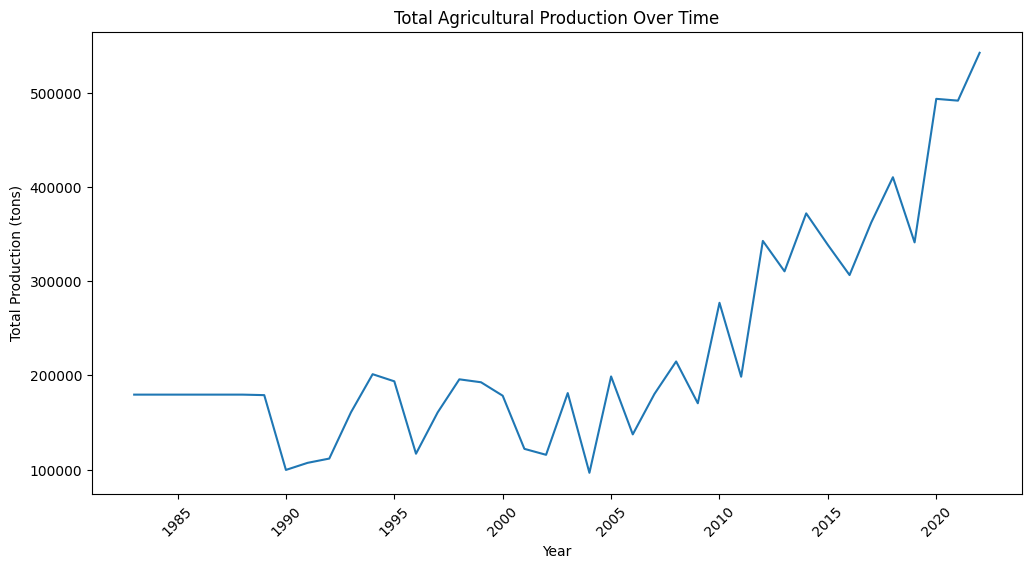

In [7]:

print("\nSummary statistics:")
display(merged_df.describe())


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_df, x='Year_Numeric', y='Total_General_Production')
plt.title('Total Agricultural Production Over Time')
plt.xlabel('Year')
plt.ylabel('Total Production (tons)')
plt.xticks(rotation=45)
plt.show()

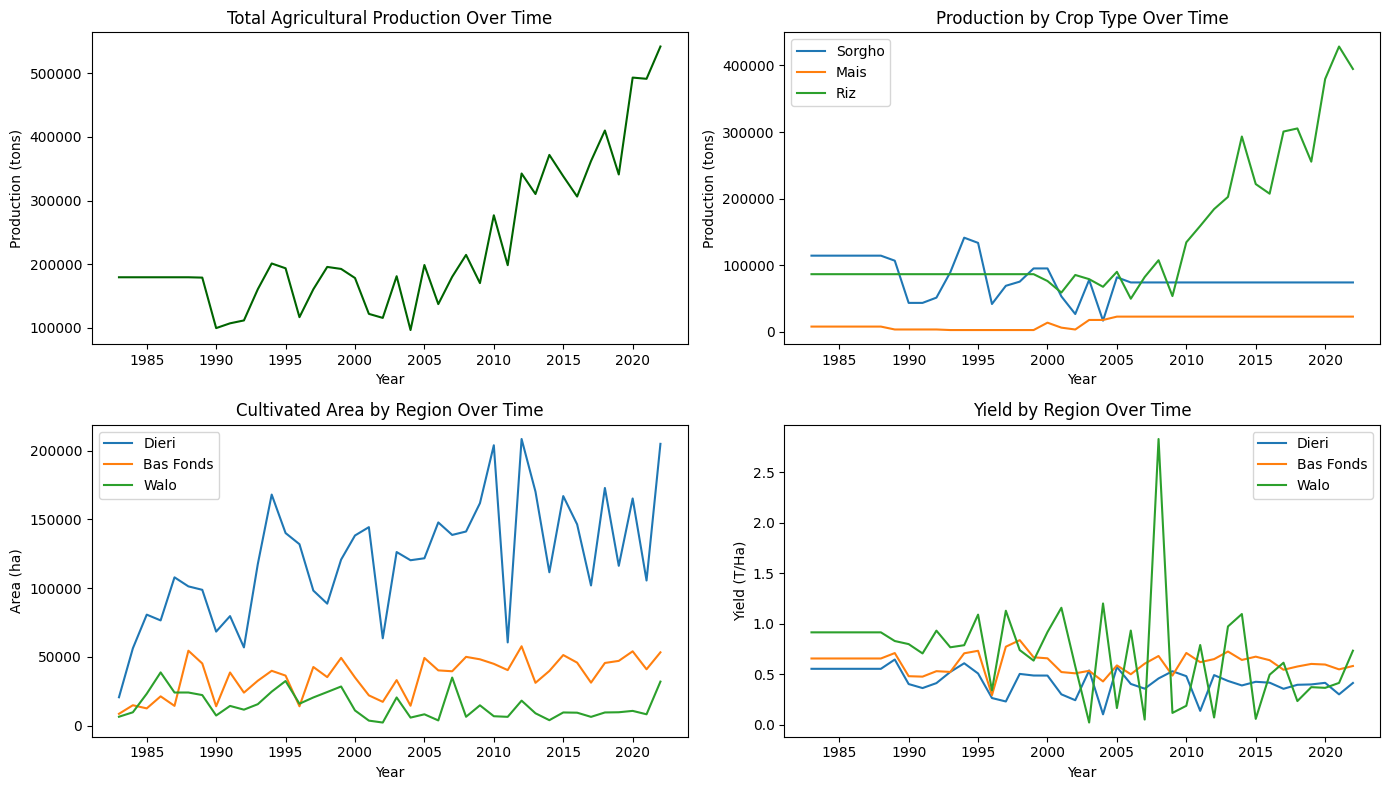

In [9]:
plt.figure(figsize=(14, 8))


plt.subplot(2, 2, 1)
sns.lineplot(data=merged_df, x='Year_Numeric', y='Total_General_Production', color='darkgreen')
plt.title('Total Agricultural Production Over Time')
plt.xlabel('Year')
plt.ylabel('Production (tons)')


plt.subplot(2, 2, 2)
sns.lineplot(data=merged_df, x='Year_Numeric', y='Total_Sorgho_Production', label='Sorgho')
sns.lineplot(data=merged_df, x='Year_Numeric', y='Total_Mais_Production', label='Mais')
sns.lineplot(data=merged_df, x='Year_Numeric', y='Total_Riz_Production', label='Riz')
plt.title('Production by Crop Type Over Time')
plt.xlabel('Year')
plt.ylabel('Production (tons)')
plt.legend()


plt.subplot(2, 2, 3)
sns.lineplot(data=merged_df, x='Year_Numeric', y='Total_Dieri_Area', label='Dieri')
sns.lineplot(data=merged_df, x='Year_Numeric', y='Total_BasFonds_Area', label='Bas Fonds')
sns.lineplot(data=merged_df, x='Year_Numeric', y='Total_Walo_Area', label='Walo')
plt.title('Cultivated Area by Region Over Time')
plt.xlabel('Year')
plt.ylabel('Area (ha)')
plt.legend()

plt.subplot(2, 2, 4)
sns.lineplot(data=merged_df, x='Year_Numeric', y='Total_Dieri_Yield', label='Dieri')
sns.lineplot(data=merged_df, x='Year_Numeric', y='Total_BasFonds_Yield', label='Bas Fonds')
sns.lineplot(data=merged_df, x='Year_Numeric', y='Total_Walo_Yield', label='Walo')
plt.title('Yield by Region Over Time')
plt.xlabel('Year')
plt.ylabel('Yield (T/Ha)')
plt.legend()

plt.tight_layout()
plt.show()

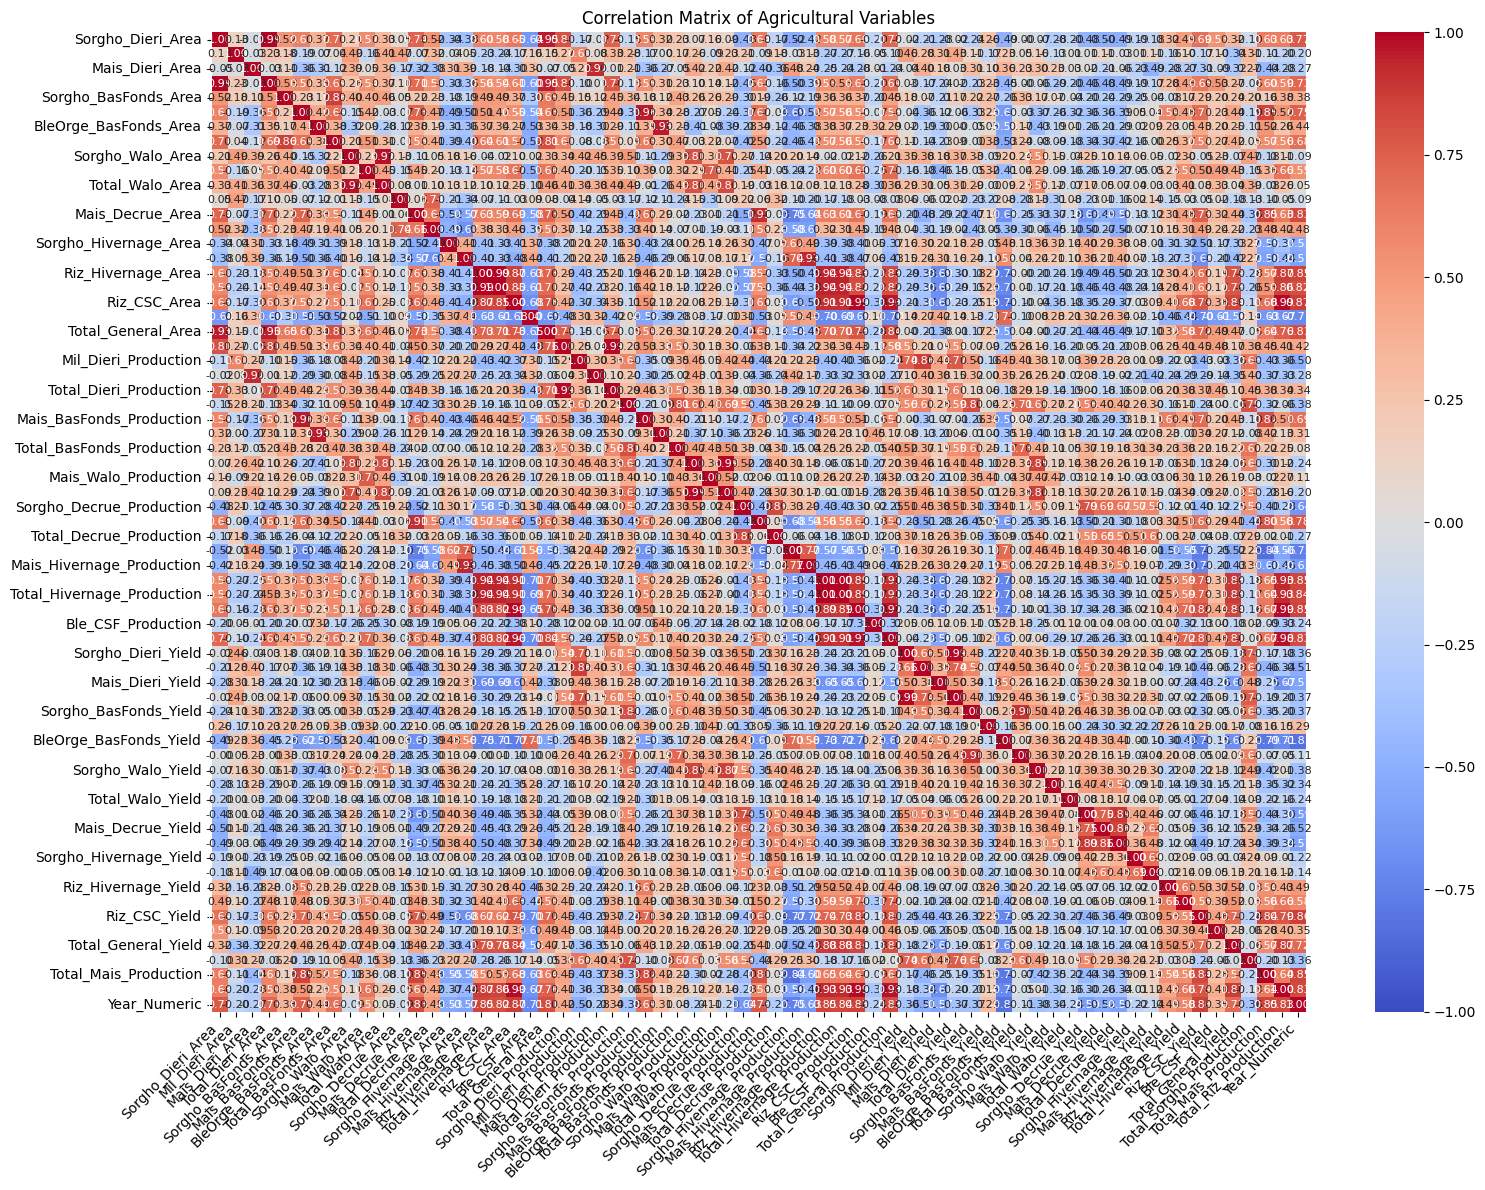

In [8]:

numeric_cols = merged_df.select_dtypes(include=[np.number]).columns
corr_df = merged_df[numeric_cols].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap='coolwarm',
            annot_kws={"size": 8}, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Agricultural Variables')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

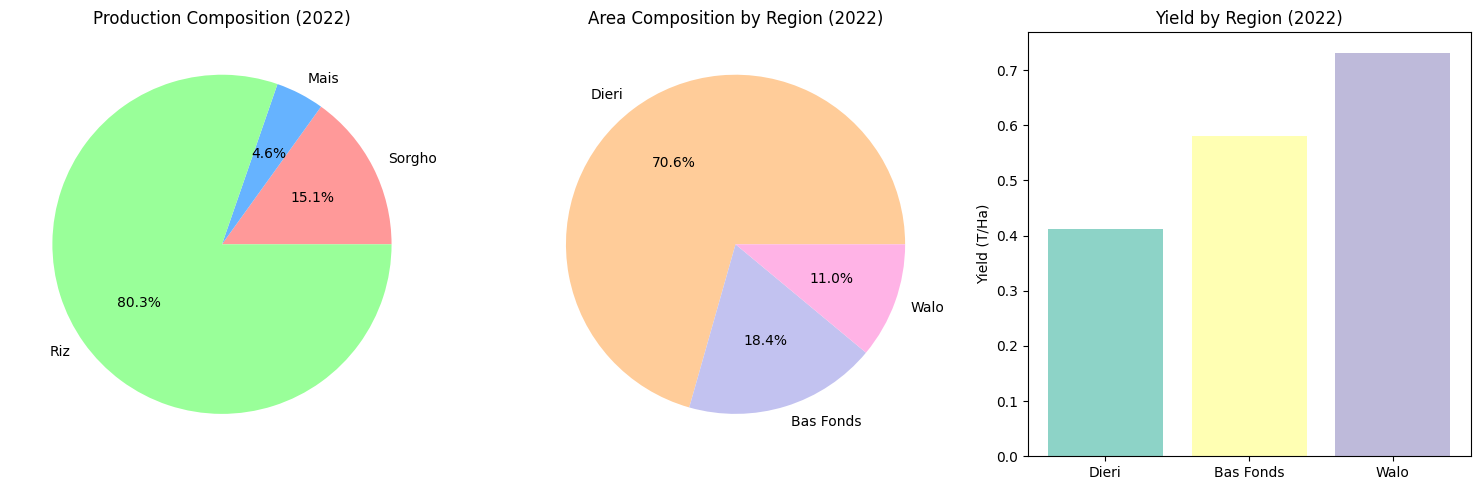

In [11]:

recent_year = merged_df['Year_Numeric'].max()
recent_data = merged_df[merged_df['Year_Numeric'] == recent_year]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
production_cols = ['Total_Sorgho_Production', 'Total_Mais_Production', 'Total_Riz_Production']

production_values = recent_data[production_cols].sum().values
plt.pie(production_values, labels=['Sorgho', 'Mais', 'Riz'],
        autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'])
plt.title(f'Production Composition ({recent_year})')


plt.subplot(1, 3, 2)
area_cols = ['Total_Dieri_Area', 'Total_BasFonds_Area', 'Total_Walo_Area']
# Calculate the sum of area for each region in the recent year
area_values = recent_data[area_cols].sum().values
plt.pie(area_values, labels=['Dieri', 'Bas Fonds', 'Walo'],
        autopct='%1.1f%%', colors=['#ffcc99','#c2c2f0','#ffb3e6'])
plt.title(f'Area Composition by Region ({recent_year})')

plt.subplot(1, 3, 3)

yield_cols = ['Total_Dieri_Yield', 'Total_BasFonds_Yield', 'Total_Walo_Yield']
yield_values = recent_data[yield_cols].mean().values
plt.bar(['Dieri', 'Bas Fonds', 'Walo'], yield_values, color=['#8dd3c7','#ffffb3','#bebada'])
plt.title(f'Yield by Region ({recent_year})')
plt.ylabel('Yield (T/Ha)')

plt.tight_layout()
plt.show()

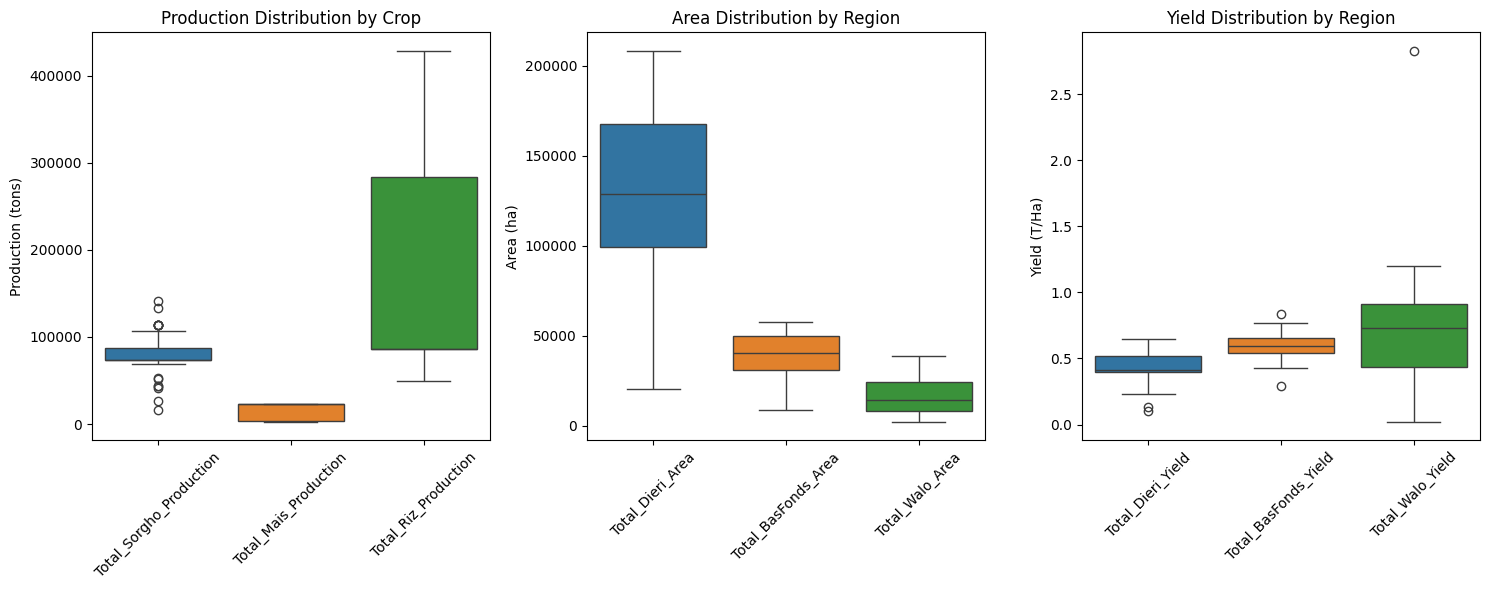

In [12]:
plt.figure(figsize=(15, 6))


plt.subplot(1, 3, 1)
sns.boxplot(data=merged_df[['Total_Sorgho_Production', 'Total_Mais_Production', 'Total_Riz_Production']])
plt.title('Production Distribution by Crop')
plt.ylabel('Production (tons)')
plt.xticks(rotation=45)


plt.subplot(1, 3, 2)
sns.boxplot(data=merged_df[['Total_Dieri_Area', 'Total_BasFonds_Area', 'Total_Walo_Area']])
plt.title('Area Distribution by Region')
plt.ylabel('Area (ha)')
plt.xticks(rotation=45)


plt.subplot(1, 3, 3)
sns.boxplot(data=merged_df[['Total_Dieri_Yield', 'Total_BasFonds_Yield', 'Total_Walo_Yield']])
plt.title('Yield Distribution by Region')
plt.ylabel('Yield (T/Ha)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

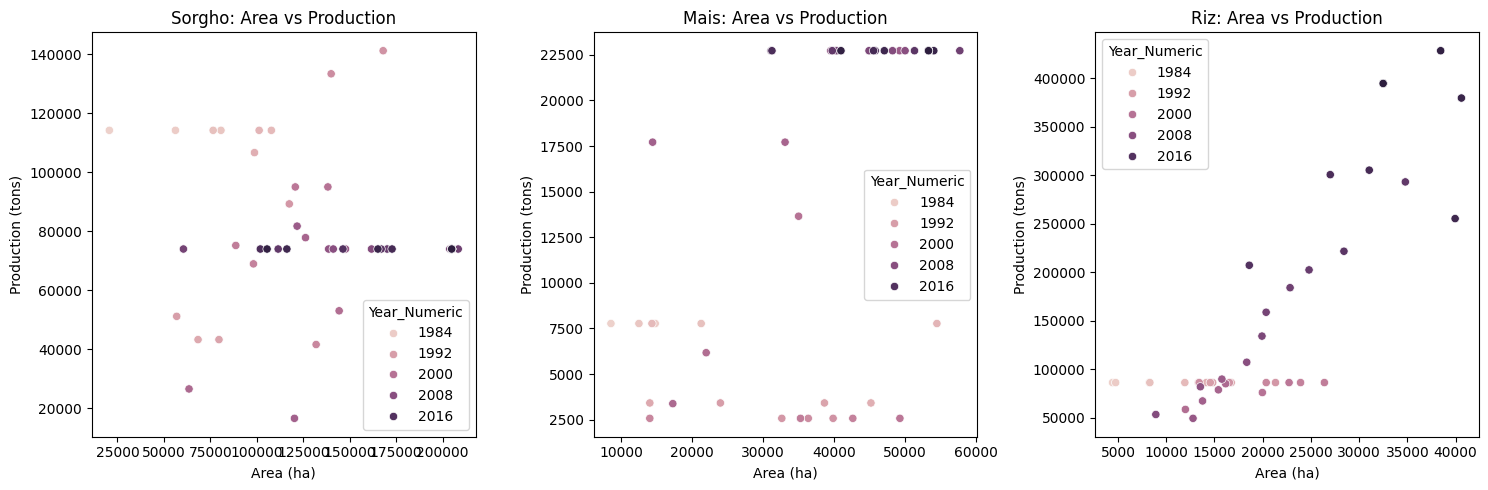

In [13]:
plt.figure(figsize=(15, 5))

# Sorgho
plt.subplot(1, 3, 1)
sns.scatterplot(data=merged_df, x='Total_Dieri_Area', y='Total_Sorgho_Production', hue='Year_Numeric')
plt.title('Sorgho: Area vs Production')
plt.xlabel('Area (ha)')
plt.ylabel('Production (tons)')

# Mais
plt.subplot(1, 3, 2)
sns.scatterplot(data=merged_df, x='Total_BasFonds_Area', y='Total_Mais_Production', hue='Year_Numeric')
plt.title('Mais: Area vs Production')
plt.xlabel('Area (ha)')
plt.ylabel('Production (tons)')

# Riz
plt.subplot(1, 3, 3)
sns.scatterplot(data=merged_df, x='Total_Hivernage_Area', y='Total_Riz_Production', hue='Year_Numeric')
plt.title('Riz: Area vs Production')
plt.xlabel('Area (ha)')
plt.ylabel('Production (tons)')

plt.tight_layout()
plt.show()

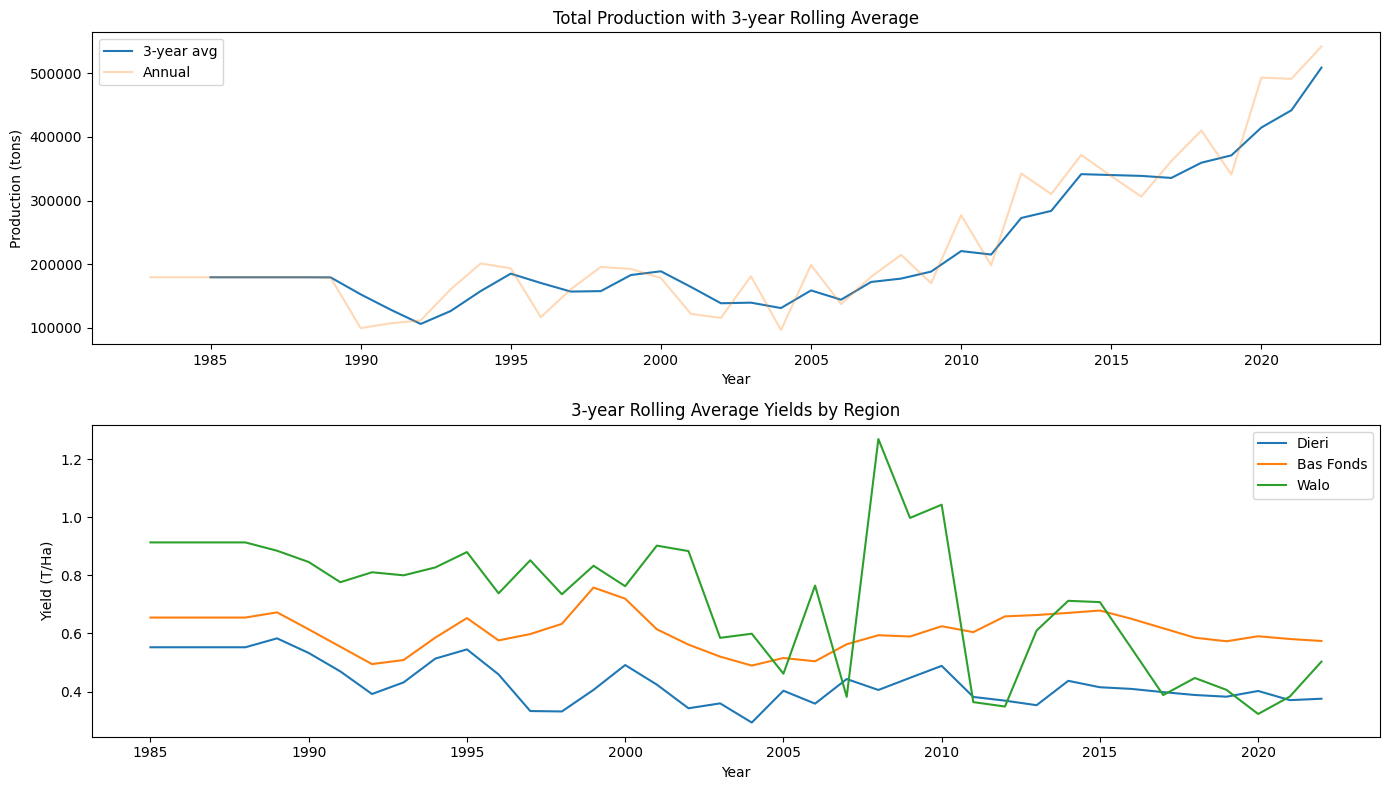

In [18]:
plt.figure(figsize=(14, 8))


numeric_merged_df = merged_df.select_dtypes(include=[np.number])


rolling_df = numeric_merged_df.groupby(merged_df['Year_Numeric']).mean().rolling(3).mean()



plt.subplot(2, 1, 1)
sns.lineplot(data=rolling_df, x=rolling_df.index, y='Total_General_Production', label='3-year avg')
sns.lineplot(data=merged_df, x='Year_Numeric', y='Total_General_Production',
             label='Annual', alpha=0.3)
plt.title('Total Production with 3-year Rolling Average')
plt.xlabel('Year')
plt.ylabel('Production (tons)')
plt.legend()

# Yield trends
plt.subplot(2, 1, 2)
if 'Total_Dieri_Yield' in rolling_df.columns:
    sns.lineplot(data=rolling_df, x=rolling_df.index, y='Total_Dieri_Yield', label='Dieri')
if 'Total_BasFonds_Yield' in rolling_df.columns:
    sns.lineplot(data=rolling_df, x=rolling_df.index, y='Total_BasFonds_Yield', label='Bas Fonds')
if 'Total_Walo_Yield' in rolling_df.columns:
     sns.lineplot(data=rolling_df, x=rolling_df.index, y='Total_Walo_Yield', label='Walo')


plt.title('3-year Rolling Average Yields by Region')
plt.xlabel('Year')
plt.ylabel('Yield (T/Ha)')
plt.legend()

plt.tight_layout()
plt.show()

#  comparing which Model is the best and then we built it from scratch

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


X = merged_df[[
    'Total_Dieri_Area', 'Total_BasFonds_Area', 'Total_Walo_Area',
    'Total_Decrue_Area', 'Total_Hivernage_Area'
]]

# Target: Total agricultural production
y = merged_df['Total_General_Production']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor


models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Support Vector': SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1),
    'K-Neighbors': KNeighborsRegressor(n_neighbors=5),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        'RMSE': rmse,
        'R2': r2,
        'Model': model
    }

<ipython-input-21-f9b9b83f1f39>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=comparison_df.index, y=comparison_df['RMSE'], palette='viridis')
<ipython-input-21-f9b9b83f1f39>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=comparison_df.index, y=comparison_df['R2'], palette='viridis')


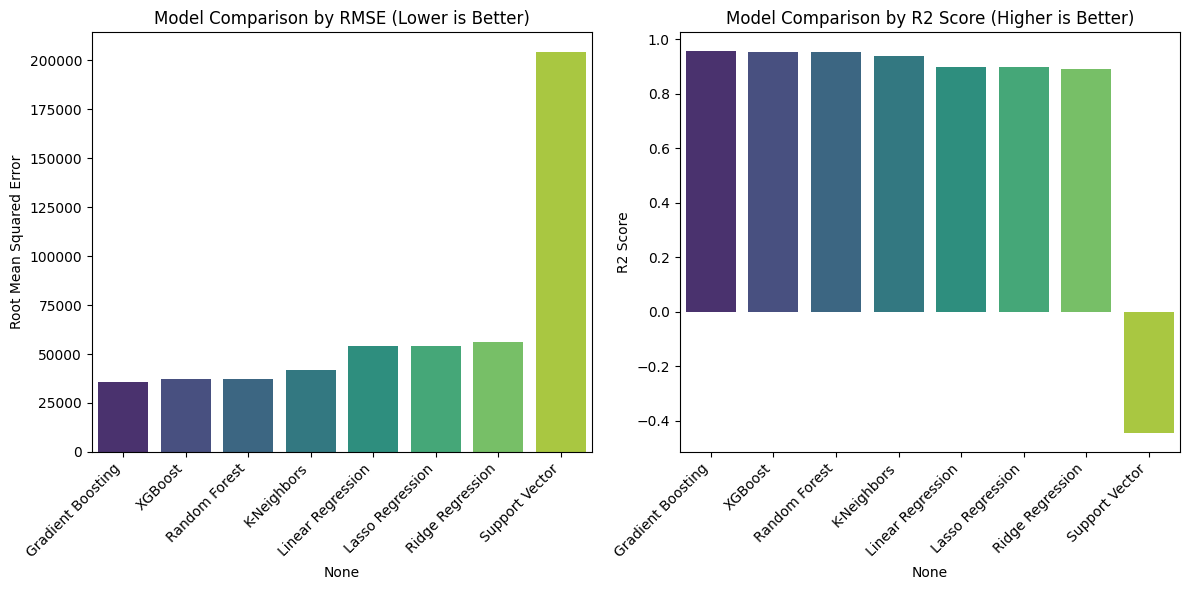

In [21]:
# Create comparison dataframe
comparison_df = pd.DataFrame.from_dict(results, orient='index')
comparison_df.sort_values('RMSE', inplace=True)

# Plot model performance
plt.figure(figsize=(12, 6))

# RMSE comparison
plt.subplot(1, 2, 1)
sns.barplot(x=comparison_df.index, y=comparison_df['RMSE'], palette='viridis')
plt.title('Model Comparison by RMSE (Lower is Better)')
plt.ylabel('Root Mean Squared Error')
plt.xticks(rotation=45, ha='right')

# R2 comparison
plt.subplot(1, 2, 2)
sns.barplot(x=comparison_df.index, y=comparison_df['R2'], palette='viridis')
plt.title('Model Comparison by R2 Score (Higher is Better)')
plt.ylabel('R2 Score')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

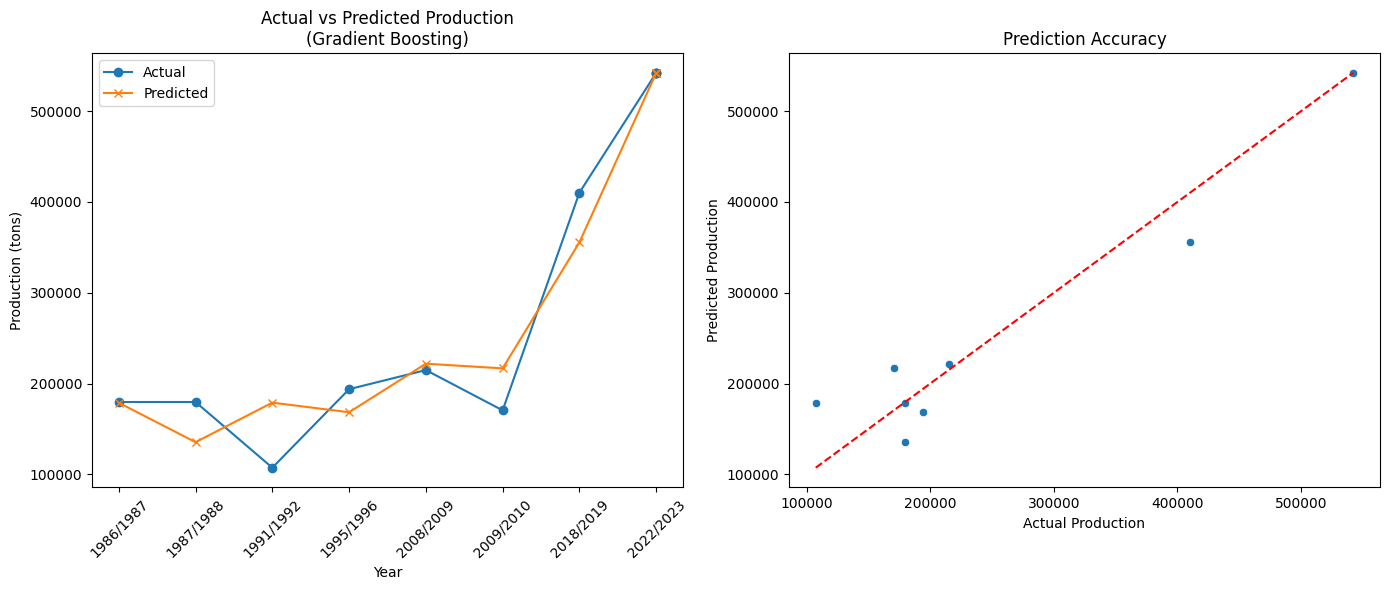

Best Model: Gradient Boosting
RMSE: 35936.27
R2 Score: 0.96


In [22]:
# Get best model based on RMSE
best_model_name = comparison_df.index[0]
best_model = comparison_df.loc[best_model_name, 'Model']

# Make predictions
y_pred = best_model.predict(X_test_scaled)

# Create prediction dataframe
pred_df = pd.DataFrame({
    'Year': merged_df.loc[X_test.index, 'Year'],
    'Actual': y_test,
    'Predicted': y_pred
}).sort_values('Year')

# Plot actual vs predicted
plt.figure(figsize=(14, 6))


plt.subplot(1, 2, 1)
plt.plot(pred_df['Year'], pred_df['Actual'], label='Actual', marker='o')
plt.plot(pred_df['Year'], pred_df['Predicted'], label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Production\n({best_model_name})')
plt.xlabel('Year')
plt.ylabel('Production (tons)')
plt.legend()
plt.xticks(rotation=45)

# Scatter plot
plt.subplot(1, 2, 2)
sns.scatterplot(x='Actual', y='Predicted', data=pred_df)
plt.plot([pred_df['Actual'].min(), pred_df['Actual'].max()],
         [pred_df['Actual'].min(), pred_df['Actual'].max()],
         'r--')
plt.title('Prediction Accuracy')
plt.xlabel('Actual Production')
plt.ylabel('Predicted Production')

plt.tight_layout()
plt.show()

print(f"Best Model: {best_model_name}")
print(f"RMSE: {comparison_df.loc[best_model_name, 'RMSE']:.2f}")
print(f"R2 Score: {comparison_df.loc[best_model_name, 'R2']:.2f}")

<ipython-input-23-d05b6df5d128>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


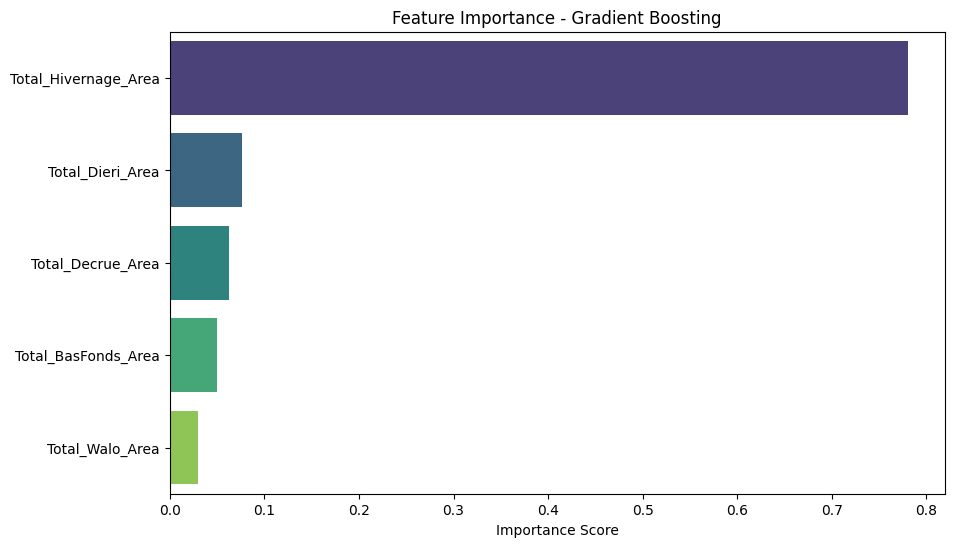

In [23]:
if hasattr(best_model, 'feature_importances_'):
    plt.figure(figsize=(10, 6))
    importances = best_model.feature_importances_
    features = X.columns
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    importance_df = importance_df.sort_values('Importance', ascending=False)

    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.xlabel('Importance Score')
    plt.ylabel('')
    plt.show()
elif hasattr(best_model, 'coef_'):
    plt.figure(figsize=(10, 6))
    coefs = best_model.coef_
    features = X.columns
    coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefs})
    coef_df = coef_df.sort_values('Coefficient', ascending=False)

    sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='viridis')
    plt.title(f'Feature Coefficients - {best_model_name}')
    plt.xlabel('Coefficient Value')
    plt.ylabel('')
    plt.show()

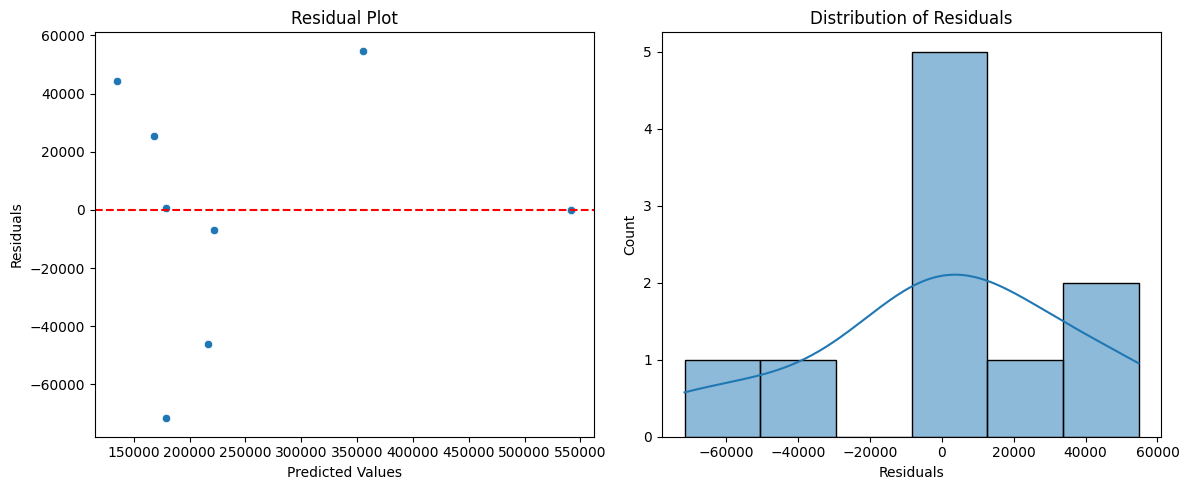

In [24]:
plt.figure(figsize=(12, 5))

# Residual plot
residuals = y_test - y_pred
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Distribution of residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')

plt.tight_layout()
plt.show()

# **Linair** Regression from scartch


In [25]:
import numpy as np

class ScratchLinearRegression:
    def __init__(self):
        self.coefficients = None
        self.intercept = None

    def fit(self, X, y):
        # Add intercept term (column of 1s)
        X = np.column_stack((np.ones(X.shape[0]), X))

        # Calculate coefficients using OLS
        XTX = np.dot(X.T, X)
        XTX_inv = np.linalg.inv(XTX)
        XTy = np.dot(X.T, y)
        beta = np.dot(XTX_inv, XTy)

        self.intercept = beta[0]
        self.coefficients = beta[1:]

    def predict(self, X):
        if self.coefficients is None:
            raise Exception("Model not fitted yet!")
        return self.intercept + np.dot(X, self.coefficients)

    def get_params(self):
        return {
            'intercept': self.intercept,
            'coefficients': self.coefficients.tolist()
        }

In [26]:

X = merged_df[[
    'Total_Dieri_Area', 'Total_BasFonds_Area', 'Total_Walo_Area',
    'Total_Decrue_Area', 'Total_Hivernage_Area'
]].values


y = merged_df['Total_General_Production'].values


def train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state:
        np.random.seed(random_state)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    split_idx = int(X.shape[0] * (1 - test_size))
    X_train, X_test = X[indices[:split_idx]], X[indices[split_idx:]]
    y_train, y_test = y[indices[:split_idx]], y[indices[split_idx:]]
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


def standard_scaler(X_train, X_test):
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    X_train_scaled = (X_train - mean) / std
    X_test_scaled = (X_test - mean) / std
    return X_train_scaled, X_test_scaled, mean, std

X_train_scaled, X_test_scaled, X_mean, X_std = standard_scaler(X_train, X_test)

In [27]:

scratch_model = ScratchLinearRegression()
scratch_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_scratch = scratch_model.predict(X_test_scaled)

# Evaluation metrics
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

scratch_rmse = np.sqrt(mean_squared_error(y_test, y_pred_scratch))
scratch_r2 = r2_score(y_test, y_pred_scratch)

print("Scratch Linear Regression Results:")
print(f"RMSE: {scratch_rmse:.2f}")
print(f"R2 Score: {scratch_r2:.2f}")
print("\nModel Parameters:")
print(scratch_model.get_params())

Scratch Linear Regression Results:
RMSE: 76801.86
R2 Score: 0.80

Model Parameters:
{'intercept': np.float64(270433.00611337717), 'coefficients': [32506.65742695851, -8283.05934691451, 26963.909701288772, 19358.844349118022, 92744.79316868237]}


In [28]:
from sklearn.linear_model import LinearRegression


sklearn_model = LinearRegression()
sklearn_model.fit(X_train_scaled, y_train)


y_pred_sklearn = sklearn_model.predict(X_test_scaled)


sklearn_rmse = np.sqrt(mean_squared_error(y_test, y_pred_sklearn))
sklearn_r2 = r2_score(y_test, y_pred_sklearn)

print("\nscikit-learn Linear Regression Results:")
print(f"RMSE: {sklearn_rmse:.2f}")
print(f"R2 Score: {sklearn_r2:.2f}")
print("\nModel Parameters:")
print(f"Intercept: {sklearn_model.intercept_}")
print(f"Coefficients: {sklearn_model.coef_}")


scikit-learn Linear Regression Results:
RMSE: 76801.86
R2 Score: 0.80

Model Parameters:
Intercept: 270433.00611337717
Coefficients: [32506.65742696 -8283.05934691 26963.90970129 19358.84434912
 92744.79316868]


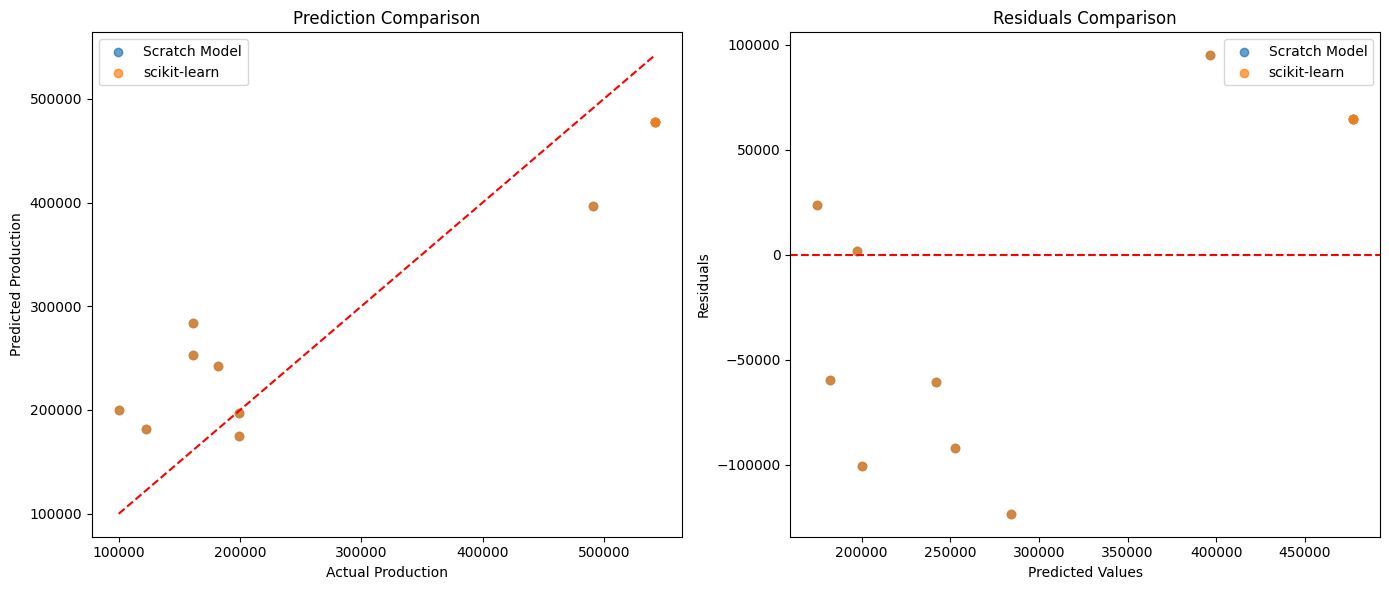


Parameter Differences:
Intercept difference: 0.000000
Average coefficient difference: 0.000000
Max coefficient difference: 0.000000


In [29]:
plt.figure(figsize=(14, 6))

# Predictions comparison
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_scratch, alpha=0.7, label='Scratch Model')
plt.scatter(y_test, y_pred_sklearn, alpha=0.7, label='scikit-learn')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Prediction Comparison')
plt.xlabel('Actual Production')
plt.ylabel('Predicted Production')
plt.legend()

# Residuals comparison
plt.subplot(1, 2, 2)
residuals_scratch = y_test - y_pred_scratch
residuals_sklearn = y_test - y_pred_sklearn
plt.scatter(y_pred_scratch, residuals_scratch, alpha=0.7, label='Scratch Model')
plt.scatter(y_pred_sklearn, residuals_sklearn, alpha=0.7, label='scikit-learn')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals Comparison')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()

plt.tight_layout()
plt.show()

# Print difference in parameters
print("\nParameter Differences:")
print(f"Intercept difference: {abs(scratch_model.intercept - sklearn_model.intercept_):.6f}")
coeff_diff = np.abs(scratch_model.coefficients - sklearn_model.coef_)
print(f"Average coefficient difference: {np.mean(coeff_diff):.6f}")
print(f"Max coefficient difference: {np.max(coeff_diff):.6f}")


Feature Coefficients Comparison:


,Feature,Scratch_Coefficient,Sklearn_Coefficient,Difference
0,Total_Dieri_Area,32506.657427,32506.657427,9.458745e-11
1,Total_BasFonds_Area,-8283.059347,-8283.059347,7.275958e-12
2,Total_Walo_Area,26963.909701,26963.909701,7.275958e-11
3,Total_Decrue_Area,19358.844349,19358.844349,1.455192e-11
4,Total_Hivernage_Area,92744.793169,92744.793169,4.365575e-11


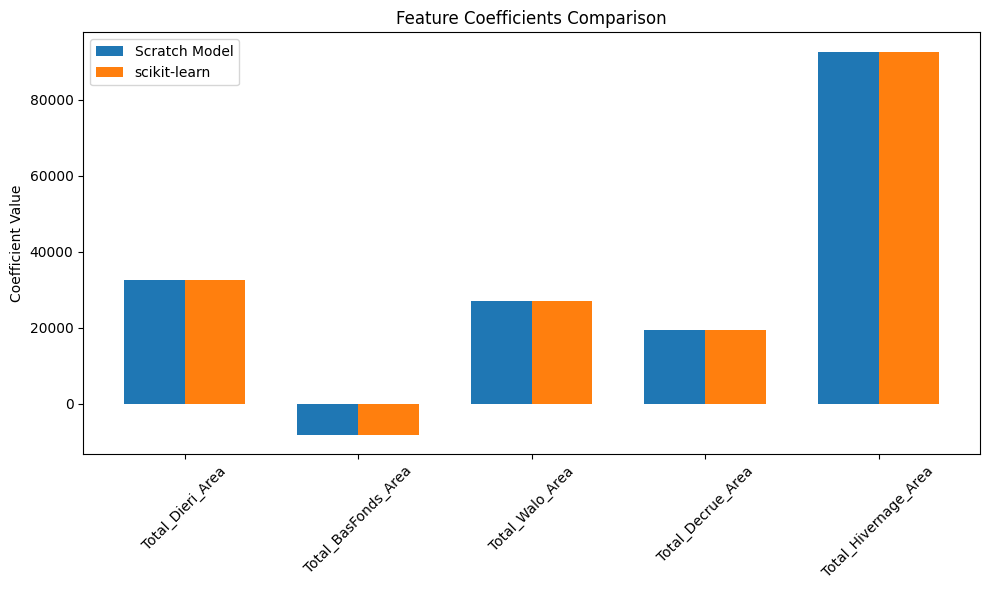

In [30]:

feature_names = [
    'Total_Dieri_Area',
    'Total_BasFonds_Area',
    'Total_Walo_Area',
    'Total_Decrue_Area',
    'Total_Hivernage_Area'
]

coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Scratch_Coefficient': scratch_model.coefficients,
    'Sklearn_Coefficient': sklearn_model.coef_,
    'Difference': coeff_diff
})

print("\nFeature Coefficients Comparison:")
display(coeff_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
x = np.arange(len(feature_names))
width = 0.35

plt.bar(x - width/2, scratch_model.coefficients, width, label='Scratch Model')
plt.bar(x + width/2, sklearn_model.coef_, width, label='scikit-learn')
plt.xticks(x, feature_names, rotation=45)
plt.ylabel('Coefficient Value')
plt.title('Feature Coefficients Comparison')
plt.legend()
plt.tight_layout()
plt.show()

In [31]:

new_data = np.array([[
    120000,
    40000,
    25000,
    8000,
    15000
]])


new_data_scaled = (new_data - X_mean) / X_std

# Make prediction
prediction = scratch_model.predict(new_data_scaled)
print(f"\nPredicted Total Production: {prediction[0]:.2f} tons")

# Compare with scikit-learn
sklearn_pred = sklearn_model.predict(new_data_scaled)
print(f"scikit-learn Prediction: {sklearn_pred[0]:.2f} tons")
print(f"Difference: {abs(prediction[0] - sklearn_pred[0]):.2f} tons")


Predicted Total Production: 227006.48 tons
scikit-learn Prediction: 227006.48 tons
Difference: 0.00 tons
